In [1]:
import keras.callbacks
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dense, Dropout
from keras.layers.recurrent import LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy.random as random

Using TensorFlow backend.


In [2]:
LOOKBACK_WINDOW = 15
PREDICT_WINDOW = 1
BATCH_SIZE = 1     #e.g if 3, then trains with 3 samples/lookback windows, each with 15 timesteps and 2 features at once before updating gradients.
HIDDEN = 32
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3

In [3]:
def coint_path(N,delta,sigma,PO):
   X = [PO]
   Y = [PO]
   for i in range(N):
      dX = random.randn()+delta*(Y[-1] - X[-1])
      X.append(X[-1]+dX)
      dY = random.randn()+sigma*(X[-1] - Y[-1])
      Y.append(Y[-1]+dY)
 
   return X,Y
 
#create artificial cointegrated series
X,Y = coint_path(60,0.9,0.1,0)

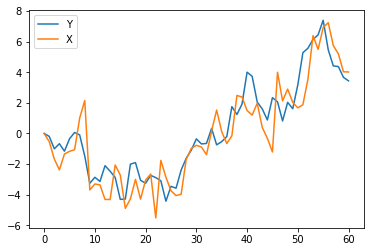

In [4]:
plt.plot(np.array(Y),label='Y')
plt.plot(np.array(X),label='X')
plt.legend()
plt.show();

In [8]:
def prep_feature_data(X,Y):
    data = np.column_stack([X,Y])
    scaler = MinMaxScaler(feature_range=(-1,1))
    data = scaler.fit_transform(data)
    return data
 
#format features for the model into a multidimensional array
data = prep_feature_data(X,Y)

In [9]:
print(data[0:3])
print(data.shape)

[[-0.13504861 -0.2513552 ]
 [-0.21911179 -0.28364562]
 [-0.39631682 -0.42104715]]
(61, 2)


In [10]:
def window_stop(data,LOOKBACK_WINDOW,PREDICT_WINDOW):
    examples = LOOKBACK_WINDOW
    y_examples = PREDICT_WINDOW
    nb_samples = len(data) - examples - y_examples #makes sure it can be split into lookback windows properly
    return nb_samples
 
#ensure it can be divided into the lookback window/batch size
nb_samples = window_stop(data,LOOKBACK_WINDOW,PREDICT_WINDOW)

In [11]:
print(nb_samples)

45


In [12]:
def input_features(nb_samples,LOOKBACK_WINDOW):
    input_list = [np.expand_dims(data[i:LOOKBACK_WINDOW+i,:], axis=0) for i in range(nb_samples)] #here nb_samples comes in handy
    input_mat = np.concatenate(input_list, axis=0)
    return input_mat
 
#format the features into the batch size
input_mat = input_features(nb_samples,LOOKBACK_WINDOW)

In [13]:
print(input_mat[0:2]) #the second sample of features will become the first sample in the next window
print(input_mat.shape)

[[[-0.13504861 -0.2513552 ]
  [-0.21911179 -0.28364562]
  [-0.39631682 -0.42104715]
  [-0.50829334 -0.36446744]
  [-0.34506659 -0.44714963]
  [-0.31788689 -0.31010218]
  [-0.30149792 -0.24059276]
  [ 0.02264356 -0.26750126]
  [ 0.20237195 -0.5008027 ]
  [-0.71332686 -0.80141906]
  [-0.65247812 -0.73542895]
  [-0.66168406 -0.78193972]
  [-0.81015372 -0.60699872]
  [-0.81173338 -0.66876699]
  [-0.45768746 -0.73755895]]

 [[-0.21911179 -0.28364562]
  [-0.39631682 -0.42104715]
  [-0.50829334 -0.36446744]
  [-0.34506659 -0.44714963]
  [-0.31788689 -0.31010218]
  [-0.30149792 -0.24059276]
  [ 0.02264356 -0.26750126]
  [ 0.20237195 -0.5008027 ]
  [-0.71332686 -0.80141906]
  [-0.65247812 -0.73542895]
  [-0.66168406 -0.78193972]
  [-0.81015372 -0.60699872]
  [-0.81173338 -0.66876699]
  [-0.45768746 -0.73755895]
  [-0.56094688 -0.97919258]]]
(45, 15, 2)


In [ ]:
def target_values(input_mat):
    targets = []
    for i in range(len(input_mat)):
        X1 = input_mat[i].T[0]
        X2 = input_mat[i].T[1]
        beta = np.polyfit(X1,X2,1)[0] #the slope is calculated from each lookback window 
        targets.appends((X1[-1] - beta*X2[-1]))
        targets = np.array(targets)
    return targets

In [57]:
#format the targets into the batch size
targets = target_values(input_mat)

AttributeError: 'list' object has no attribute 'appends'

In [49]:
def basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets):
    num_features = input_mat.shape[2] #this is the same as input dimension, used in describing batch_input_shape
    model = Sequential()
    
    model.add(LSTM(HIDDEN,batch_input_shape=(BATCH_SIZE,LOOKBACK_WINDOW,num_features)))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1)) #the output is one dimensional
    
    model.compile(loss='mse',optimizer=OPTIMIZER)
    #history = LossHistory()
    predictions,actuals,scores = [],[],[]
    
    assert(len(input_mat)==len(targets)) #checks each sample has a corresponding target value 
    
    for i in range(1,len(input_mat)):
        trainX = input_mat[0:i]
        trainY = targets[0:i]
        testX = input_mat[i].reshape(1,input_mat[0].shape[0],input_mat[0].shape[1]) #convert the input into 3 dimensional array
        testY = np.array([targets[i]]).reshape(1,1) #convert the target value into a 2 dimensional array
  
 #walk forward training, to predict the next timestep 
 #you can adjust the verbose parameter to 1 or 2 to watch the LSTM's progress 
    model.fit(trainX,trainY,nb_epoch=EPOCHS,batch_size=BATCH_SIZE,callbacks=[history],verbose=0)
    prediction = model.predict(testX,batch_size=BATCH_SIZE) 
    score = model.evaluate(testX,testY,batch_size=BATCH_SIZE,verbose=0)
    
    predictions.append(prediction[0][0])
    actuals.append(targets[i])
    scores.append(score)
    
    return model,history,predictions,actuals,scores

In [50]:
def evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores):
   print(np.mean(scores[int(len(scores)*0.75):])) #since the latter predictions have been trained on more data, we take the average of the testing loss scores for the last quarter of predictions
  
   plt.figure(1)
   plt.plot(history.losses)
   plt.title('Loss History')
   plt.figure(2)
   plt.plot(scores)
   plt.title('Testing Loss')
   plt.figure(3)
   plt.plot(actuals,'b-',label='actual')
   plt.plot(predictions,'g-',label='prediction')
   plt.title('Basic LSTM')
   plt.legend()
   plt.grid('on')
   plt.show()

In [51]:
LOOKBACK_WINDOW = 15
PREDICT_WINDOW = 1
BATCH_SIZE = 1 #e.g if 3, then trains with 3 samples/lookback windows, each with 15 timesteps and 2 features at once.
HIDDEN = 32
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3
 
model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores)

AssertionError: 